Will save this model to ./exps/exp5
experiment parameters {'dim': 136, 'no_batches_ep': 3, 'shuffle': True, 'exp_id': './exps/exp5', 'batch_size': 144, 'epoch_size': 3, 'n_splits': 2}


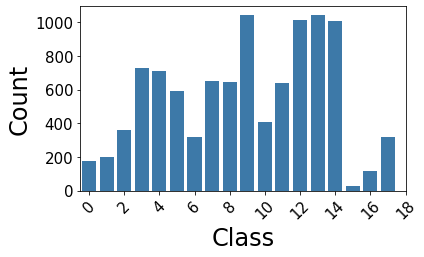

Got 10000  data  samples. Hyperparameters were: f-> [ 10  75 250] x [0.125 0.175 0.225] err [0.5 1. ]
------------------Printing stats for main generator------------------
f,x,err,count
0-0-0 174
0-0-1 1043
0-1-0 201
0-1-1 407
0-2-0 363
0-2-1 639
1-0-0 728
1-0-1 1015
1-1-0 710
1-1-1 1043
1-2-0 593
1-2-1 1010
2-0-0 318
2-0-1 28
2-1-0 649
2-1-1 115
2-2-0 644
2-2-1 320
Total number of samples: 10000
----------------------------------------------Training member 1 of ensemble...----------------------------------------------
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m (InputLayer)               [(None, 136, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 136, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 136, 32)           31

----------------------------------------------
training took: 10.908709049224854 seconds
----------------------------------------------
classifier predicting on its val data, whose shape is (5005, 136, 1) (5005, 18)
shape of predictions of whole dataset,  (5005, 18)
classifier predicting on its val data, whose shape is (4995, 136, 1) (4995, 18)
shape of predictions of whole dataset,  (4995, 18)


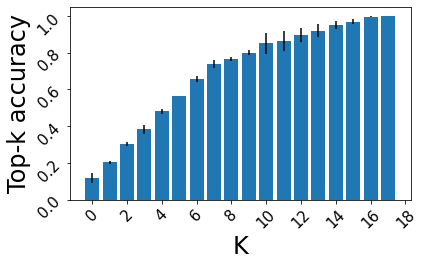

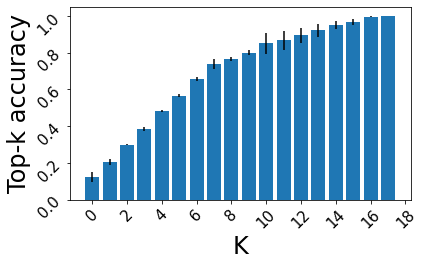

In [1]:
from train_convnet_sigma_err import *
main(['', 'exp5'])